<a href="https://colab.research.google.com/github/fatemafaria142/English-Natural-Language-Inference-in-Extended-Textual-Contexts-Using-Pretrained-BERT-Models/blob/main/Natural_Language_Inference_using_mBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,log_loss,jaccard_score,roc_auc_score,classification_report,confusion_matrix
from torch.utils.data import Dataset, DataLoader

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Train Dataset**

In [ ]:
# Read JSON Lines file
df_train = pd.read_json("/content/drive/MyDrive/train.jsonl", lines=True)
# Display the first few rows of the DataFrame
df_train.head()

,uid,premise,hypothesis,label
0,id_0,100 Years of the Western Workplace Conditions ...,Improvements in medicine led to workers earnin...,n
1,id_1,100 Years of the Western Workplace Conditions ...,"In 1900, 19% of North American women of workin...",c
2,id_2,100 Years of the Western Workplace Conditions ...,The appearance of shanty towns after farmers m...,e
3,id_3,100 Years of the Western Workplace Conditions ...,America and Europe shared the same overall tre...,n
4,id_4,100 Years of the Western Workplace Conditions ...,No significant drawbacks accompanied changes i...,c


# **Test Dataset**

In [ ]:
# Read JSON Lines file
df_test = pd.read_json("/content/drive/MyDrive/test.jsonl", lines=True)
# Display the first few rows of the DataFrame
df_test.head()

,uid,premise,hypothesis,label
0,id_803,"some time on the night of October 1st, the Cop...","If the insurance company pays out in full, Joh...",n
1,id_0,This passage provides information on the subsi...,Government subsidiary could reduce renewable e...,e
2,id_1,This passage provides information on the subsi...,Fossil-fuels are currently cheaper than forms ...,e
3,id_2,This passage provides information on the subsi...,The average temperature in the UK is set to ri...,c
4,id_3,This year most of the shops and departmental s...,Lots of goods are available but the sale is no...,e


# **Validation Dataset**

In [ ]:
# Read JSON Lines file
df_validation = pd.read_json("/content/drive/MyDrive/dev.jsonl", lines=True)
# Display the first few rows of the DataFrame
df_validation.head()

,uid,premise,hypothesis,label
0,id_0,The concept of childhood in the western countr...,In 20 th century almost all children needed to...,n
1,id_1,The concept of childhood in the western countr...,"By the aid of half-time schools, most children...",c
2,id_2,The concept of childhood in the western countr...,the rise of trade union majorly contributed to...,n
3,id_3,The concept of childhood in the western countr...,Scientists think that overworked labor damages...,e
4,id_4,The concept of childhood in the western countr...,Aries pointed out that children did different ...,c


# **Visualization of Label Distribution in Train dataset**
* Entailment - e
* Contradiction - c
* Neutral - n

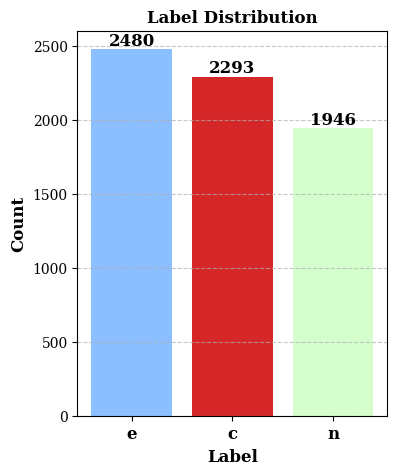

In [ ]:
label_counts = df_train['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(4, 5))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Test dataset**
* Entailment - e
* Contradiction - c
* Neutral - n

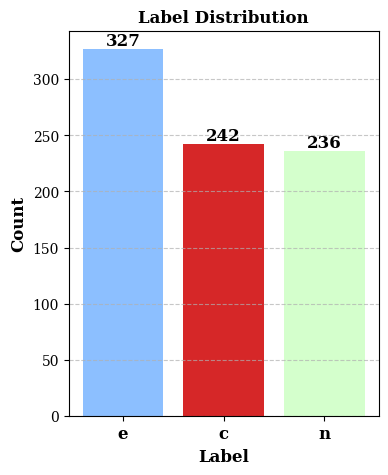

In [ ]:
label_counts = df_test['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(4, 5))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Label Distribution in Validation dataset**
* Entailment - e
* Contradiction - c
* Neutral - n

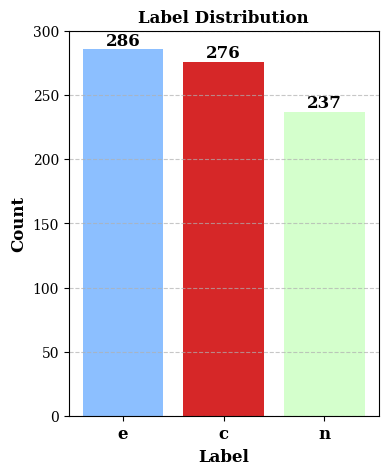

In [ ]:
label_counts = df_validation['label'].value_counts()

# Define custom colors for the bars ('e', 'c', and 'n')
custom_colors = ['#8cbfff', '#d62728','#d4ffcc']

# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

plt.figure(figsize=(4, 5))

# Create bar plot with grid
bars = plt.bar(label_counts.index, label_counts.values, color=custom_colors)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Label Distribution', fontdict=font)
plt.xlabel('Label', fontdict=font)
plt.ylabel('Count', fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(label_counts.index, label_counts.index, fontdict=font)
plt.yticks(fontname='Serif', fontsize=10)

# Adding annotations (count values) on top of each bar
for bar, count in zip(bars, label_counts.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontdict=font)

# Show the plot
plt.show()


# **Visualization of Premise Length Distribution in Train Dataset**

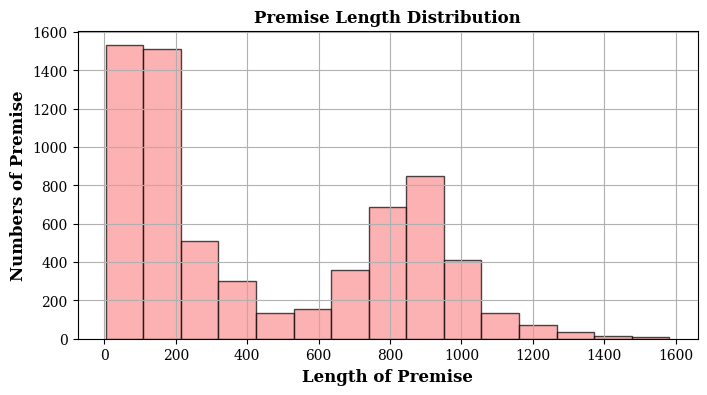

In [ ]:
# Visualize premise length distribution
premise_lengths = df_train['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(8, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Test Dataset**

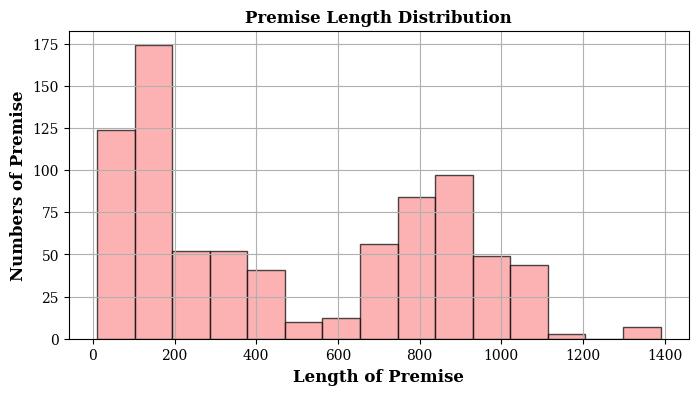

In [ ]:
# Visualize premise length distribution
premise_lengths = df_test['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(8, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
plt.grid(True)
plt.show()

# **Visualization of Premise Length Distribution in Validation Dataset**

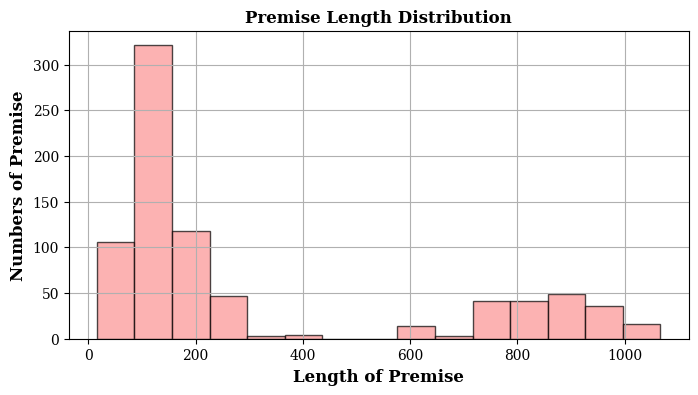

In [ ]:
# Visualize premise length distribution
premise_lengths = df_validation['premise'].apply(lambda x: len(x.split()))
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}
custom_colors = ['#fc9292']
plt.figure(figsize=(8, 4))
plt.hist(premise_lengths, bins=15, color=custom_colors,edgecolor='black' ,alpha=0.7)

# Set title and axis labels using custom fontdict
plt.title('Premise Length Distribution',fontdict=font)
plt.xlabel('Length of Premise',fontdict=font)
plt.ylabel('Numbers of Premise',fontdict=font)

# Set custom font for ticks on both x and y axes
plt.xticks(fontname='Serif', fontsize=10)
plt.yticks(fontname='Serif', fontsize=10)
plt.grid(True)
plt.show()

# **Dataset Length**

In [ ]:
print(f"Train Dataset Length: {len(df_train)}")
print(f"Test Dataset Length: {len(df_test)}")
print(f"Validation Dataset Length:{len(df_validation)}")

Train Dataset Length: 6719
Test Dataset Length: 805
Validation Dataset Length:799


# **Null value checking in Train dataset**

In [ ]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_train['premise'].isnull().sum()
null_hypothesis = df_train['hypothesis'].isnull().sum()
null_label = df_train['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **Null value checking in Test dataset**

In [ ]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_test['premise'].isnull().sum()
null_hypothesis = df_test['hypothesis'].isnull().sum()
null_label = df_test['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **Null value checking in Validation dataset**

In [ ]:
# Check for null values in 'premise', 'hypothesis' and	'label' columns
null_premise = df_validation['premise'].isnull().sum()
null_hypothesis = df_validation['hypothesis'].isnull().sum()
null_label = df_validation['label'].isnull().sum()


print(f"Null values in 'premise': {null_premise}")
print(f"Null values in 'hypothesis': {null_hypothesis}")
print(f"Null values in 'label': {null_label}")


Null values in 'premise': 0
Null values in 'hypothesis': 0
Null values in 'label': 0


# **mBERT model and its tokenizer**

In [ ]:
from transformers import BertTokenizer, BertModel,AdamW
# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

In [ ]:
# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

# **Custom Dataset Class**

In [ ]:
class NaturalLanguageInferenceDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.label_map = {'e': 0, 'c': 1, 'n': 2}  # Mapping labels to integers

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        premise = self.data.iloc[idx]['premise']
        hypothesis = self.data.iloc[idx]['hypothesis']
        label = self.data.iloc[idx]['label']

        # Map label to integer
        label_id = self.label_map[label]

        # Tokenize premise and hypothesis separately
        encoded_dict_premise = self.tokenizer.encode_plus(
            premise,
            add_special_tokens=True,
            max_length=self.max_length // 2,  # Allocate half of the max_length to each
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        encoded_dict_hypothesis = self.tokenizer.encode_plus(
            hypothesis,
            add_special_tokens=True,
            max_length=self.max_length // 2,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        # Concatenate input_ids and attention_masks
        input_ids = torch.cat((encoded_dict_premise['input_ids'], encoded_dict_hypothesis['input_ids']), dim=1)
        attention_mask = torch.cat((encoded_dict_premise['attention_mask'], encoded_dict_hypothesis['attention_mask']), dim=1)

        return {
            'input_ids': input_ids.squeeze(),
            'attention_mask': attention_mask.squeeze(),
            'label': torch.tensor(label_id, dtype=torch.long)  # Use mapped label_id
        }


# **Custom dataset and dataloader**

In [ ]:
# Define custom datasets
train_dataset = NaturalLanguageInferenceDataset(df_train, tokenizer)
val_dataset = NaturalLanguageInferenceDataset(df_validation, tokenizer)
test_dataset = NaturalLanguageInferenceDataset(df_test, tokenizer)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# **Train Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,  14535,  51747,  10134,  48886,  10162,  10841,  10271,  16328,
         61285,  27867,  10271,  10134,  10893,  12373,  10271,  12172,  10472,
         84630,  17864,  10165,    119,  14235,  10944,  12962,  28569,  10455,
         17574,  10142,  31324,  11152,  10635,  11360,  10689,  14095,  10950,
         10108,  37021,  10111,  14982,  15148,  10114,  32198,  10105,  13621,
         23722,  37725,  55869,    119,  10313,  50736, 110068,  27570,  11850,
         10189,  10108,  10105,  10609,  10859,  10944,  12962,  28569,  10474,
         17574,  10142,  10855,  10111,  13621,  23722,  70863,  10151,  50736,
        110068,  24074,  10108,  55869,  11360,  10105,  10106,  44082,  30434,
        105315,    119,  10117,  49148,  11046,  25738,  10841,  16683,  11299,
         10108,  10105,  27953,  11991,  10155,  59320,  37021,  16379,  10309,
         15337,    119,  10117,  10536,  12397,  19423,  58040,  10114,  10105,
         22859,  10155,  1816

# **Test Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,  11152,  10635,  10135,  10105,  16903,  10108,  11212,  13510,
           117,  10105,  13150,  10425,  31380,  11316,  10134,  11499,  13061,
         10123,  10114,  10105,  16912,    119,  10117,  15034,  10301,  81634,
         10230,  10105,  13559,  10146,  10846,  34891,  25087,    119,  10117,
         10893,  73367,  11053,  10160,  10531,  15365,  10301,    131,  10117,
         11111,  10134,  15498, 101350,  10142,  10798,  11084,  10474,  13486,
         19211,    119,  10117,  11111,  55893,  10114,  10421, 107570,    119,
         10468,  38508,  14598,  77155,  12704,  10134,  11053,  10114,  27920,
         15805,  10421, 107570,    119,  22036,  11212,  13510,  10111,  11212,
         14105,    117,  10468,  38508,  14598,  77155,  12704,  10134,  14942,
         10188,  11816,  10135,    169,  14155,  37307,    119,  11723,  10309,
         10192,  71126,  17285,    119,    138,  13065,  10108,  10105,  11111,
         10134,  11823,  1010

# **Validation Dataset Encoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}  # Using 'batch' directly

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Print information
    print("Input IDs:", input_ids)
    print("Attention Mask:", attention_mask)
    print("Labels:", labels)


    # Break out of the loop after processing the first batch
    break


Input IDs: tensor([   101,  10117,  19228,  10108,  42645,  10106,  10105,  16672,  15911,
         10117,  11486,  10108,  42645,  10393,  10590,    169,  57680,  10108,
         17644,  10106,  12142,  11486,  11764,  10105,  22625,  17306,  10699,
         12748,  52013,  13091,  10171,  10108,  21640,  30123,    117,  13398,
         10155,  11894,  27914,  15408, 110140,  10107,    119,  10357,  35525,
         10189,  42645,  10124,    169,  19228,  13745,  10155,  13456,  19912,
           119,  11340,  10108,  10105,  10992,  29698,  10454,  29632,  10162,
         17850,  10106,  10105,  11486,  10108,  42645,  10393,  10590,  21883,
         42645,  10124,  17587,    169,  19037,  66626,    119,  10117,  27914,
         15408, 110140,  10107,  35525,  10189,  10106,  13163,  11767,  10939,
         10105,  15441,  30834,    113,  10741,  10114,  10978,  10105,  11572,
         10108,  10105,  58305,  11143,  11943,    114,  12694,  10309,  34937,
         10146,  25103,  4470

# **Train Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in train_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: A common difficulty faced by business managers is when the behaviour of a team - member conflicts with established desirable practice. How does a good leader handle such an issue? One effective angle is to lead by example : instead of waiting for a problem to develop, take a proactive approach in heading it off with reference to clearly laid out guidelines. If a problematic situation does develop, controlling it can be made simpler by invoking existing values from a mission statement which has been set out in advance. A good team will always put the needs of the organisation first. Taking such an approach gives the team a sense of personal involvement which encourages them to feel part of the organisation's mission, internalising the needs of the group rather than feeling a sense of externally imposed obligation. It provides team members with a greater sense of personal control, the sense that they have contributed individually, and by choice, to the well - being of

# **Test Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in test_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: some time on the night of October 1st, the Copacabana Club was burnt to the ground. The police are treating the fire as suspicious. The only facts known at this stage are : The club was insured for more than its real value. The club belonged to John Hodges. Les Braithwaite was known to dislike John Hodges. Between October 1st and October 2nd, Les Braithwaite was away from home on a business trip. There were no fatalities. A plan of the club was found in Les Braithwaite's flat. If the insurance company pays out in full, John Hodges stands to profit from the fire.
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

# **Validation Dataset Decoding Printing**

In [ ]:
# Set a flag to track whether it's the first batch
first_batch = True

for batch in val_loader:
    # Move inputs and labels to the GPU
    inputs = {key: value.to(device) for key, value in batch.items()}

    # Extract information for the first example in the batch
    input_ids = inputs['input_ids'][0]
    attention_mask = inputs['attention_mask'][0]
    labels = inputs['label'][0]


    # Check for problematic token IDs causing overflow error during decoding
    problematic_ids = torch.nonzero((input_ids < 0) | (input_ids >= tokenizer.vocab_size))
    if problematic_ids.numel() > 0:
        print("Problematic Token IDs:", input_ids[problematic_ids])
        print("Problematic Token Positions:", problematic_ids)
        # Handle the problematic input IDs as needed
        raise ValueError("Problematic token IDs detected")

    # Decode and print input text
    decoded_input_text = tokenizer.decode(input_ids.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Decoded Input Text:", decoded_input_text)
    print("Attention Mask:", attention_mask)

    # Decode and print labels
    decoded_labels = tokenizer.decode(labels.clamp(0, tokenizer.vocab_size - 1), skip_special_tokens=True)
    print("Labels:", decoded_labels)



    # Break out of the loop after processing the first batch
    break


Decoded Input Text: The concept of childhood in the western countries The history of childhood has been a topic of interest in social history since the highly influence 1960 book Centuries of Childhood, written by French historian Philippe Aries. He argued that childhood is a concept created by modern society. One of the most hotly debated issues in the history of childhood has been whether childhood is itself a recent invention. The historian Philippe Aries argued that in Western Europe during the Middle Ages ( up to about the end of the fifteenth century ) children were regarded as miniature adults, with all the intellect and personality that this implies. He scrutinized medieval pictures and diaries, and found no distinction between children and adults as they shared similar leisure activities and often the same type of work. Aries, however, pointed out that this is not to suggest that children were neglected, forsaken or despised. The idea of childhood is not to be confused with af

# **Custom Classifier**

In [ ]:
# Define classifier
classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 3)
)

# Place model on the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
classifier.to(device)


Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
)

# **Optimizer and Loss Function**

In [ ]:
# Define optimizer and loss function
optimizer = torch.optim.AdamW(classifier.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# **Training the model**

In [ ]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    classifier.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output.to(device)

        classifier_outputs = classifier(pooled_output)
        loss = criterion(classifier_outputs, labels)
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Average training loss: {avg_train_loss}')

    # Validation
    classifier.eval()
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Validation'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output.to(device)

            classifier_outputs = classifier(pooled_output)
            _, predicted = torch.max(classifier_outputs, 1)

            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_labels, val_preds)
    print(f'Validation Accuracy: {val_accuracy}')

Epoch 1/1: 100%|██████████| 672/672 [04:38<00:00,  2.41it/s]


Average training loss: 1.0945700875350408


Validation: 100%|██████████| 80/80 [00:30<00:00,  2.62it/s]

Validation Accuracy: 0.3591989987484355


# **Testing the model**

In [ ]:
classifier.eval()
test_preds = []
test_labels = []
test_probs = []  # Store predicted probabilities

with torch.no_grad():
    for batch in tqdm(test_loader, desc='Testing'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output.to(device)

        classifier_outputs = classifier(pooled_output)
        probabilities = torch.softmax(classifier_outputs, dim=1)  # Softmax to get probabilities
        _, predicted = torch.max(classifier_outputs, 1)

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probabilities.cpu().numpy())  # Append predicted probabilities

test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='macro')
test_recall = recall_score(test_labels, test_preds, average='macro')
test_f1 = f1_score(test_labels, test_preds, average='macro')
test_jaccard_score = jaccard_score(test_labels, test_preds, average='macro')
test_log_loss = log_loss(test_labels, test_probs)

Testing: 100%|██████████| 81/81 [00:32<00:00,  2.47it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(test_preds)
print(test_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')
print(f'Test F1 Score: {test_f1}')
print(f'Test Jaccard Score: {test_jaccard_score}')
print(f'Log Loss: {test_log_loss}')

Test Accuracy: 0.4012422360248447
Test Precision: 0.1763383521539105
Test Recall: 0.3296139038424276
Test F1 Score: 0.1936512455516014
Test Jaccard Score: 0.13517077453621634
Log Loss: 1.0897202747655381


In [ ]:
from sklearn.preprocessing import LabelBinarizer
# Convert labels to one-hot encoded format
label_binarizer = LabelBinarizer()
test_labels_one_hot = label_binarizer.fit_transform(test_labels)

# Reshape the one-hot encoded labels
num_classes = len(label_binarizer.classes_)
test_labels_one_hot = test_labels_one_hot.reshape(-1, num_classes)

# Creating a 2D array for test_preds
num_samples = len(test_preds)
num_classes = len(label_binarizer.classes_)
formatted_preds = [[0] * num_classes for _ in range(num_samples)]
for i, pred in enumerate(test_preds):
    formatted_preds[i][pred] = 1

# Calculate ROC AUC score for multiclass classification
test_roc_auc_score = roc_auc_score(test_labels_one_hot, formatted_preds, average='macro', multi_class='ovo')
print("Test ROC AUC Score:", test_roc_auc_score)

Test ROC AUC Score: 0.4971140782691556


In [ ]:
# Mapping numeric labels to category names
label_map = {0: 'Entailment', 1: 'Contradiction', 2: 'Neutral'}

# Convert numeric predictions to label names
predicted_labels = [label_map[pred] for pred in test_preds]
true_labels = [label_map[label] for label in test_labels]

# Generate and print the classification report
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

Contradiction       0.12      0.00      0.01       242
   Entailment       0.40      0.98      0.57       327
      Neutral       0.00      0.00      0.00       236

     accuracy                           0.40       805
    macro avg       0.18      0.33      0.19       805
 weighted avg       0.20      0.40      0.24       805



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


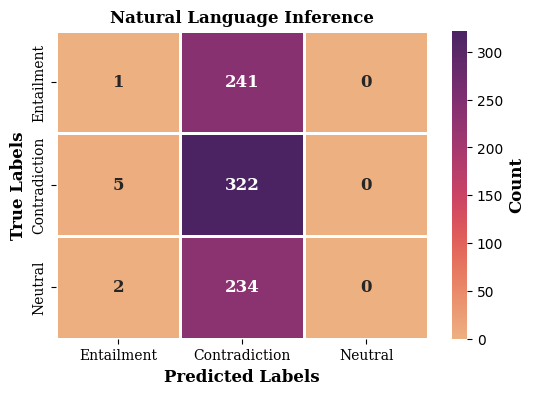

In [ ]:
# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
# Define the custom palette
custom_palette = sns.color_palette("flare", as_cmap=True) # Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette, linewidths=2, linecolor='white',
                      xticklabels=['Entailment', 'Contradiction', 'Neutral'], yticklabels=['Entailment', 'Contradiction', 'Neutral'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Natural Language Inference', fontdict=font)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=10)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)

plt.show()


In [ ]:
# Combine the lists into a DataFrame
data = {'Premise': df_test['premise'],
        'Hypothesis': df_test['hypothesis'],
        'True_Labels': df_test['label'],
        'Predicted_Labels': test_preds}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('predicted_results.csv', index=False)


In [ ]:
# Save the model
model.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_Model.pt')

# Save the tokenizer
tokenizer.save_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_Tokenizer.json')

# Save the classifier separately using torch.save
torch.save(classifier.state_dict(), "/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_classifier.pth")



In [ ]:

# load the model
model.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_Model.pt')

# load the tokenizer
tokenizer.from_pretrained('/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_Tokenizer.json')

'''
This piece of code is needed before calling classifier.load_state_dict() to ensure that
the loaded state dictionary gets applied to the correct architecture.
'''
classifier = torch.nn.Sequential(
    torch.nn.Linear(768, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 3)
)
# load the classifier separately
classifier.load_state_dict(torch.load("/content/drive/MyDrive/Natural_Language_Inference/NLI_mBERT/NLI_mBERT_classifier.pth"))


<All keys matched successfully>